In [1]:
import csv
import cv2
import numpy as np

lines=[]
with open ('/Users/thiyagarajanramanathan/Desktop/Udacity-training/data/driving_log.csv') as csvfile:
    reader=csv.reader(csvfile)
    for line in reader:
        lines.append(line)


In [2]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

In [3]:
##Data Visualization
images=[]
angles=[]
for line in lines:
    source_path=line[0]
    filename=source_path.split('/')[-1]
    current_path='/Users/thiyagarajanramanathan/Desktop/Udacity-training/data/IMG/' +filename
    image=cv2.imread(current_path)
    images.append(image)
    angles.append(float(line[3]))

In [4]:
images=np.asarray(images)
angles=np.asarray(angles)

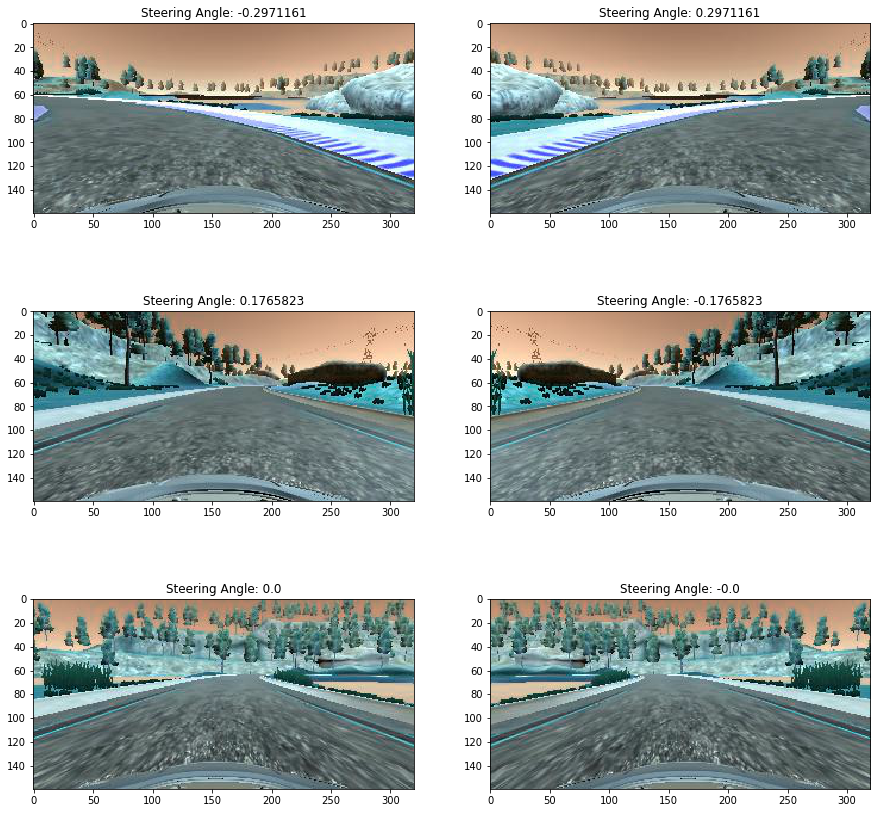

In [36]:
import random
import numpy as np
import matplotlib.pyplot as plt
f, ax = plt.subplots(3,2,figsize=(15,15))
for i in range(3):
    for j in range(1):
        index=random.randint(0,len(images))
        ax[i,0].imshow(images[index,:,:,:])
        ax[i,0].set_title('Steering Angle: {}'.format(angles[index]))
        image=images[index,:,:,:]
        ax[i,1].imshow(np.fliplr((image)))
        ax[i,1].set_title('Steering Angle: {}'.format(-angles[index]))
    

(array([6.000e+00, 7.000e+00, 1.010e+02, 3.940e+02, 5.767e+03, 1.405e+03,
        3.040e+02, 4.400e+01, 6.000e+00, 2.000e+00]),
 array([-0.9426954 , -0.74842586, -0.55415632, -0.35988678, -0.16561724,
         0.0286523 ,  0.22292184,  0.41719138,  0.61146092,  0.80573046,
         1.        ]),
 <a list of 10 Patch objects>)

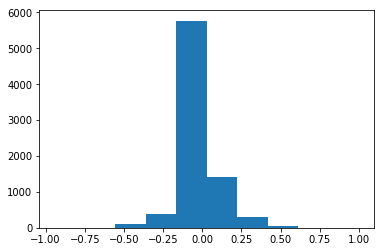

In [49]:
##To get the histogram of the 
plt.hist(angles)

In [5]:
import cv2
import numpy as np
import sklearn
import random

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                choice=np.random.choice(3)
                name = '/Users/thiyagarajanramanathan/Desktop/Udacity-training/data/IMG/'+batch_sample[choice].split('/')[-1]
                image = cv2.imread(name)
                if choice==0:
                    angle = float(batch_sample[3])
                elif choice==1:
                    angle = float(batch_sample[3])+0.2
                else:
                    angle = float(batch_sample[3])-0.2
                ##Pre Processing
                ##Converting the color space
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                ##Cropping the image
                image=image[50:140,:,:]
                ##Resizing the image
                image=cv2.resize(image, (200,66), interpolation = cv2.INTER_AREA)
                ##Flipping the images in random
                if random.uniform(0,1)<0.5:
                    image = np.fliplr(image)
                    angle = -angle    
                images.append(image)
                angles.append(angle)


            # trim image to only see section with road
            X_train = np.array(images)/127.5-1.0
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


    

In [4]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Cropping2D, Dropout, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.backend import tf as ktf

model=Sequential()
model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='relu',input_shape=(66,200,3),subsample=(2,2)))
model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu',subsample=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu',subsample=(2,2)))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')




Using TensorFlow backend.
/home/thiyagu_1405/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., padding="valid", strides=(2, 2), activation="relu")`
  import sys
/home/thiyagu_1405/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="valid", strides=(2, 2), activation="relu")`
  
/home/thiyagu_1405/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), padding="valid", strides=(2, 2), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/home/thiyagu_1405/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), 

'\nmodel.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same",input_shape=(66,200,3), activation=\'elu\'))\nmodel.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation=\'elu\'))\nmodel.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation=\'elu\'))\nmodel.add(Flatten())\nmodel.add(Dropout(.2))\nmodel.add(Dense(512, activation=\'elu\'))\nmodel.add(Dropout(.5))\nmodel.add(Dense(1))\n'

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 18, 64)         0         
__________

In [7]:
model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=3)

/home/thiyagu_1405/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/home/thiyagu_1405/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=6428, validation_steps=1608, validation_data=<generator..., epochs=3)`
  """Entry point for launching an IPython kernel.


Epoch 1/3
6428/6428 [==============================] - 1072s 167ms/step - loss: 0.0142 - val_loss: 0.0148
Epoch 2/3
6428/6428 [==============================] - 1052s 164ms/step - loss: 0.0106 - val_loss: 0.0138
Epoch 3/3
6428/6428 [==============================] - 1046s 163ms/step - loss: 0.0092 - val_loss: 0.0128


In [8]:
model.save('model.h5')